In [19]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Warningds
import warnings
warnings.filterwarnings('ignore')

c:\Users\Nilla\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Nilla\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Nilla\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [20]:
import zipfile

zip_path = "../dataset-tomat.zip"
extract_path = "/content/tomato"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [21]:
data_path = '/content/tomato'

In [22]:
filepaths = []
labels = []

In [23]:
def is_image_valid(filepath):
    try:
        img = Image.open(filepath)  # Mencoba membuka gambar
        img.verify()  # Memeriksa integritas gambar
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image found and skipped: {filepath}")
        return False

In [ ]:
folds = os.listdir(data_path)
for fold in folds:
    f_path = os.path.join(data_path, fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))

# Membaca file .jpg dari seluruh subdirektori
for root, dirs, files in os.walk(data_path):
    for file in files:
        filepath = os.path.join(root, file)
        if filepath.endswith('.jpg') and is_image_valid(filepath): # Memeriksa format gambar dan apakah gambar valid
            # Menyimpan path file dan label (nama folder induk)
            filepaths.append(filepath)
            labels.append(os.path.basename(root))  # Nama subfolder sebagai label

In [25]:
# Membuat DataFrame untuk file path dan label
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
train_df = pd.concat([Fseries, Lseries], axis=1)

In [26]:
# Mengecek total nilai NaN di seluruh DataFrame
train_df.isna().sum().sum()

np.int64(1)

In [27]:
# Cek dan hapus baris dengan NaN jika ada
train_df.dropna(inplace=True)

In [28]:
# Memeriksa jumlah gambar setelah pembersihan
print(f"Total images after cleaning: {len(train_df)}")
print(train_df.head())  # Menampilkan beberapa baris dari DataFrame

Total images after cleaning: 6487
                                           filepaths    label
0               /content/tomato\content\ieee-mbl-cls  Damaged
1  /content/tomato\content\ieee-mbl-cls\train\Dam...  Damaged
2  /content/tomato\content\ieee-mbl-cls\train\Dam...  Damaged
3  /content/tomato\content\ieee-mbl-cls\train\Dam...  Damaged
4  /content/tomato\content\ieee-mbl-cls\train\Dam...  Damaged


In [29]:
print(train_df['label'].value_counts())

label
Old        2214
Ripe       2195
Unripe     1419
Damaged     659
Name: count, dtype: int64


In [61]:
print(train_gen.class_indices)


{'Damaged': 0, 'Old': 1, 'Ripe': 2, 'Unripe': 3}


In [30]:
# Split data ke training, validation, dan testing
train_df, test_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

In [31]:
# Pengaturan untuk ImageDataGenerator dan ukuran gambar
img_size = (224, 224)  # ukuran lebih kecil untuk mempercepat
batch_size = 16

In [32]:
# Augmentasi data untuk pelatihan dan uji
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='label', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='label', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='label', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
)

Found 4150 validated image filenames belonging to 4 classes.
Found 1038 validated image filenames belonging to 4 classes.
Found 1298 validated image filenames belonging to 4 classes.


In [33]:
# Mendapatkan kelas dan contoh gambar
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

# # Mendapatkan jumlah kelas
# classes = list(train_gen.class_indices.keys())
num_class = len(classes) # num_class is correctly calculated here based on train_gen

# Membangun model CNN sederhana
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_class, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

# Pelatihan model
Epochs = 20
history = model.fit(train_gen, 
                    epochs=Epochs, 
                    validation_data=valid_gen, 
                    shuffle=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 90s 341ms/step - accuracy: 0.6027 - loss: 10.2379 - val_accuracy: 0.6763 - val_loss: 0.8013
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 96s 367ms/step - accuracy: 0.6622 - loss: 0.8980 - val_accuracy: 0.7563 - val_loss: 0.7261
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 90s 348ms/step - accuracy: 0.6294 - loss: 0.7914 - val_accuracy: 0.7514 - val_loss: 0.6505
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 89s 344ms/step - accuracy: 0.4966 - loss: 1.2555 - val_accuracy: 0.5183 - val_loss: 1.0159
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 90s 346ms/step - accuracy: 0.5443 - loss: 0.9748 - val_accuracy: 0.5462 - val_loss: 0.8914
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 89s 344ms/step - accuracy: 0.6058 - loss: 0.8809 - val_accuracy: 0.6696 - val_loss: 0.8008
Epoch 7/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 89s 342ms/step - accuracy: 0.6345 - loss: 0.8263 - val_accuracy: 0.7129 - val_loss: 0.7595
Epoch 8/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 89s 341ms/step - accuracy: 0.6434 - loss: 

In [37]:
def save_cnn_model(model, path="model/cnn_model"):
    model.save(path)
    print(f"CNN model saved to {path}")

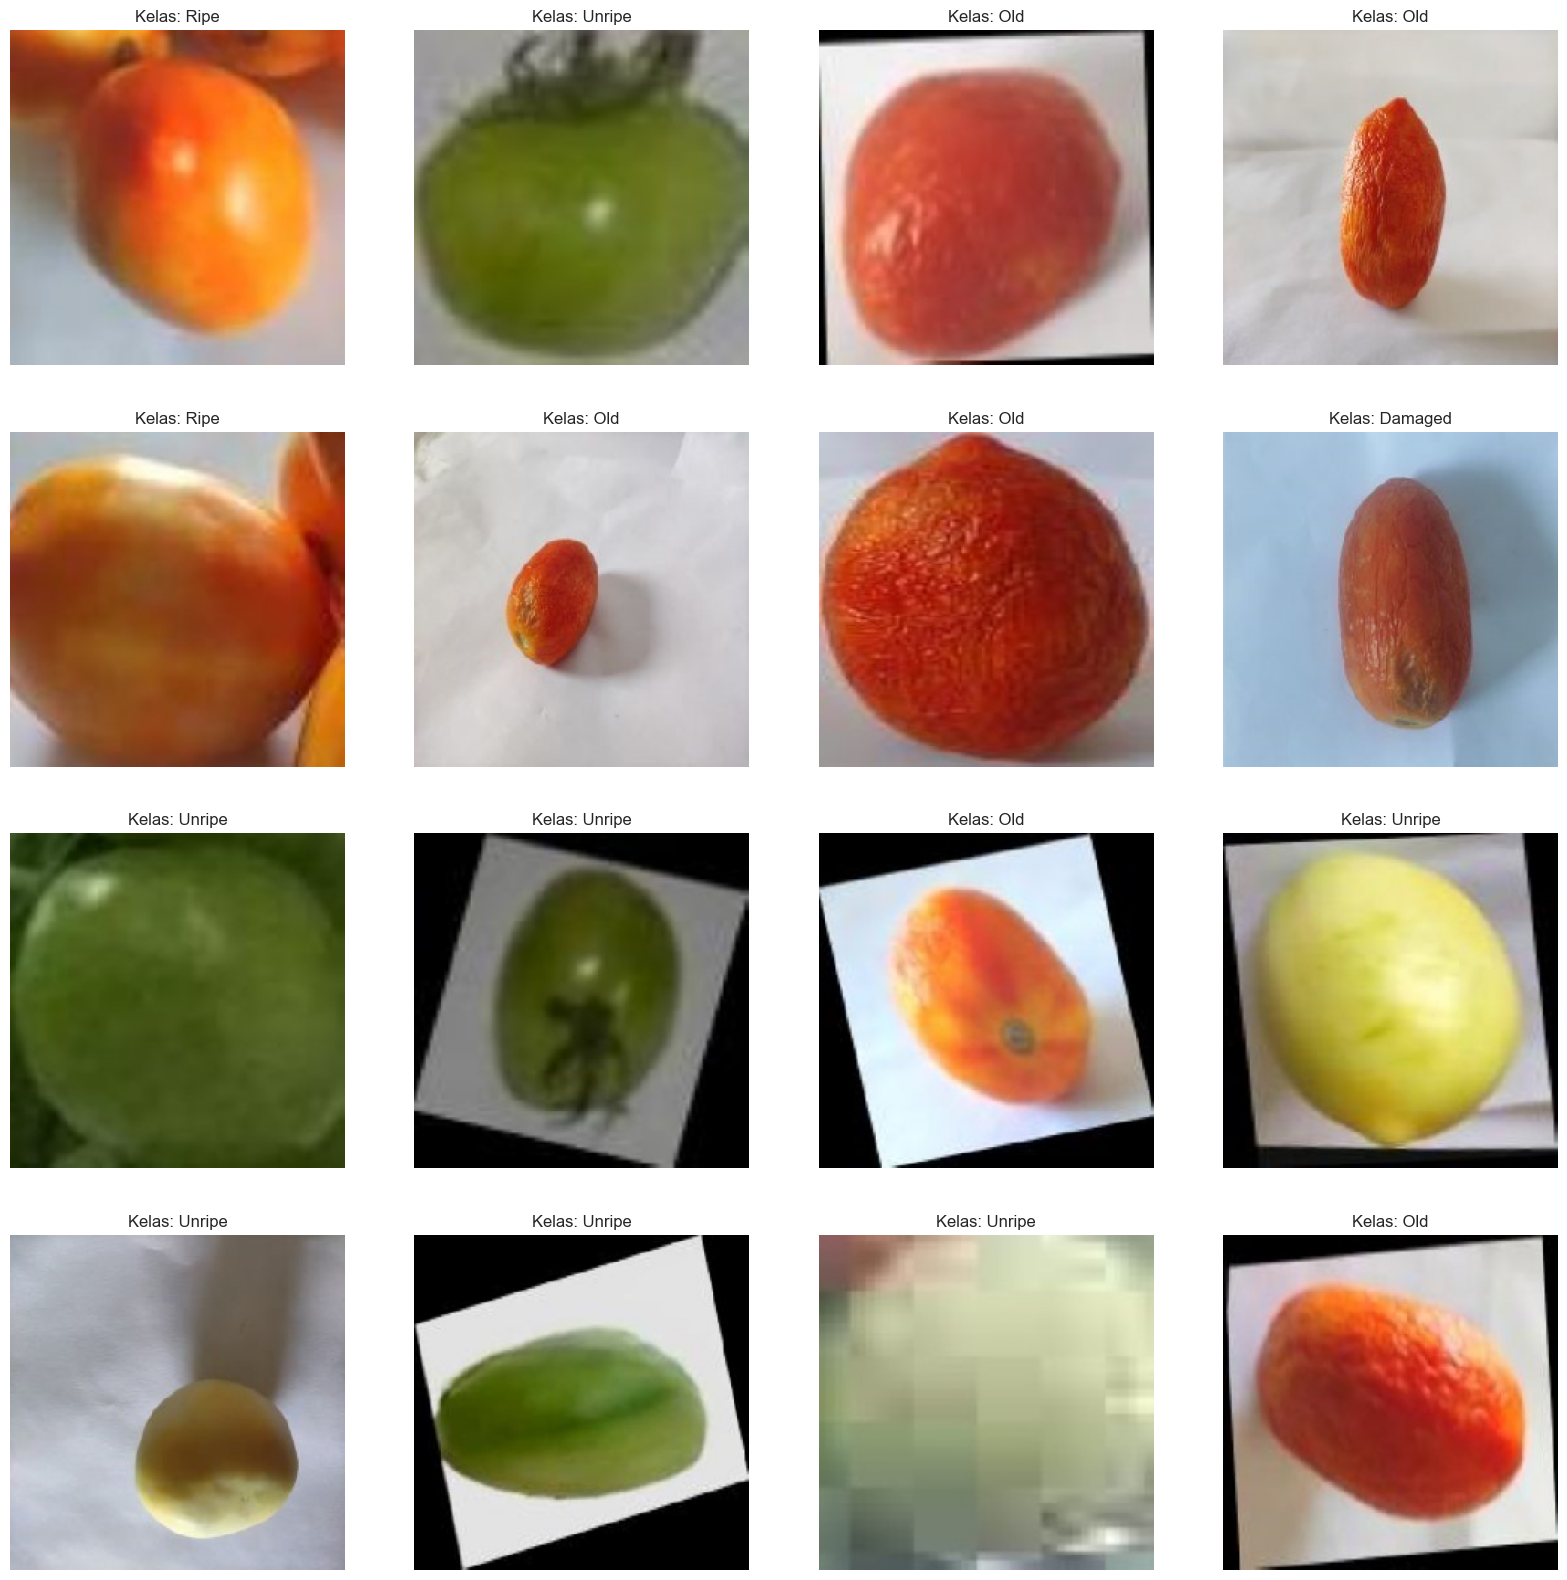

In [38]:
# Menampilkan contoh gambar
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(f"Kelas: {class_name}")
    plt.axis('off')

plt.show()

In [57]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.Collecting scikit-image
   ---------------------------------------- 0.0/11.9 MB ? eta -:--:--
    --------------------------------------- 0.3/11.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.9 MB 2.3 MB/s eta 0:00:05
   ----- ---------------------------------- 1.6/11.9 MB 2.9 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/11.9 MB 2.7 MB/s eta 0:00:04
   -------- ------------------------------- 2.6/11.9 MB 2.7 MB/s eta 0:00:04
   ------------ --------------------------- 3.7/11.9 MB 3.1 MB/s eta 0:00:03
   -------------- ------------------------- 4.5/11.9 MB 3.3 MB/s eta 0:00:03
   ------------------ --------------------- 5.5/11.9 MB 3.5 MB/s eta 0:00:02
   -------------------- ------------------- 6.0/11.9 MB 3.5 MB/s eta 0:00:02
   ---------------------- ----------------- 6.8/11.9 MB 3.5 MB/s eta 0:00:02
   --------------------------- ------------ 8.1/11.9 MB 3.6 MB/s eta 0:00:02
 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops

In [46]:
def extract_features(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Gagal membaca gambar: {image_path}")
        return [np.nan] * 12   # jumlah fitur

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = rgb2gray(img)

    mean_r = np.mean(img[:,:,0])
    std_r  = np.std(img[:,:,0])
    mean_g = np.mean(img[:,:,1])
    std_g  = np.std(img[:,:,1])
    mean_b = np.mean(img[:,:,2])
    std_b  = np.std(img[:,:,2])

    gray_uint8 = (gray * 255).astype(np.uint8)

    glcm = graycomatrix(
        gray_uint8,
        distances=[5],
        angles=[0],
        levels=256,
        symmetric=True,
        normed=True
    )

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    ASM = graycoprops(glcm, 'ASM')[0, 0]

    return [
        mean_r, std_r, mean_g, std_g, mean_b, std_b,
        contrast, dissimilarity, homogeneity, energy, correlation, ASM
    ]


In [47]:
train_df['filepaths'] = train_df['filepaths'].str.replace(
    '/content/tomato/content/',
    '/content/tomato/',
    regex=False
)


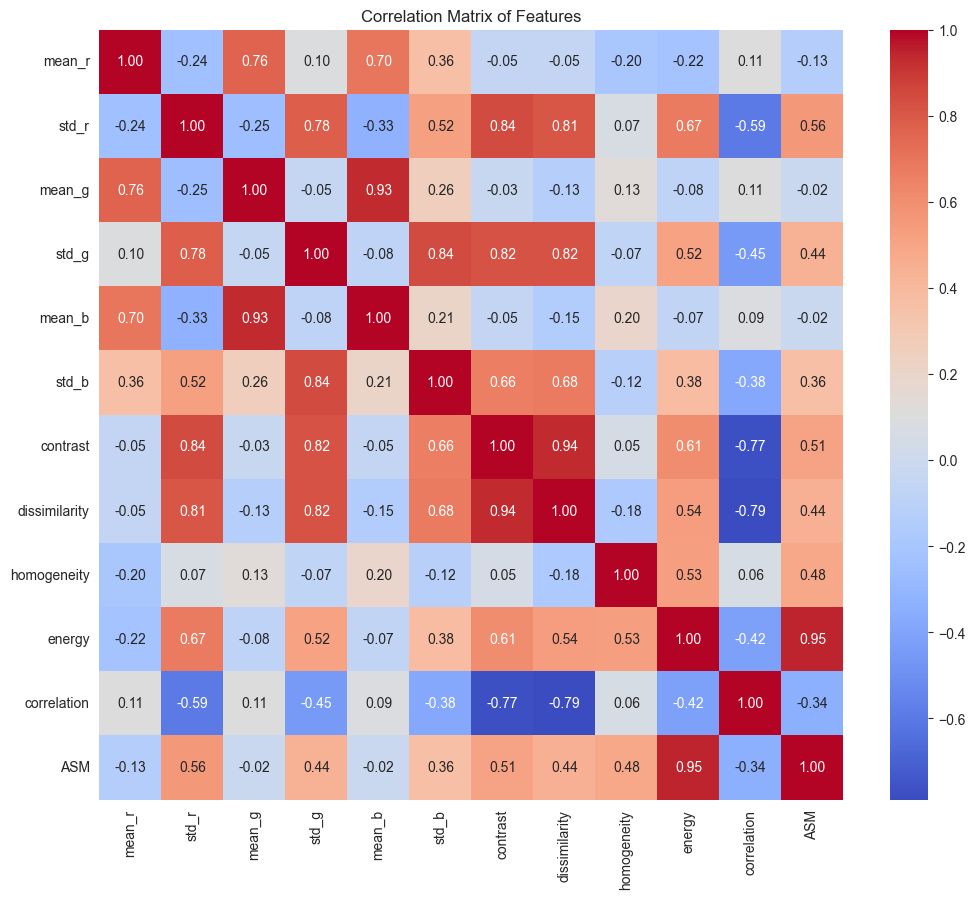

In [70]:
# Example: Correlation matrix to see relationships between features.
correlation_matrix = train_df[feature_names].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

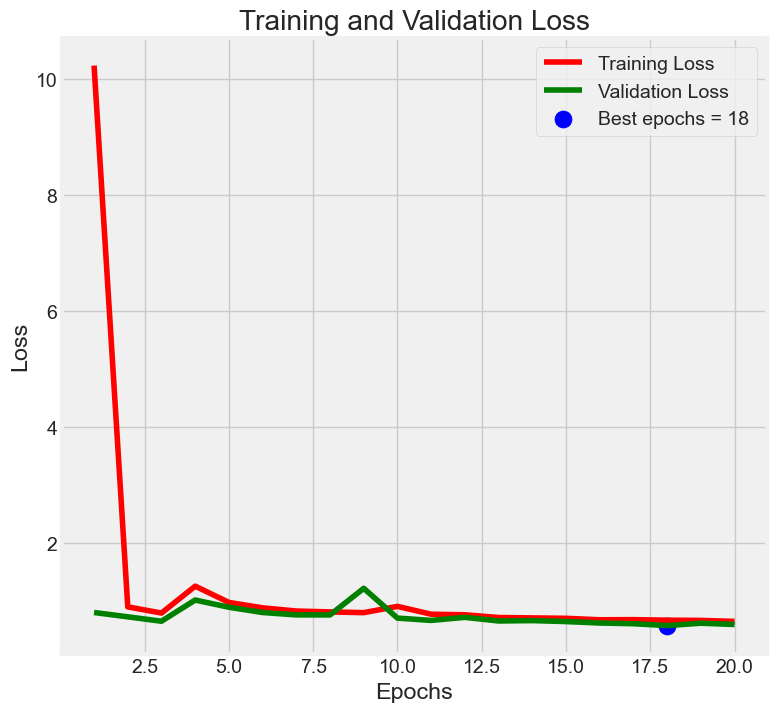

In [49]:
# Menampilkan hasil pelatihan
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
Epochs = [i + 1 for i in range(len(train_acc))]
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]


loss_label = f'Best epochs = {str(index_loss + 1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

#Plot Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

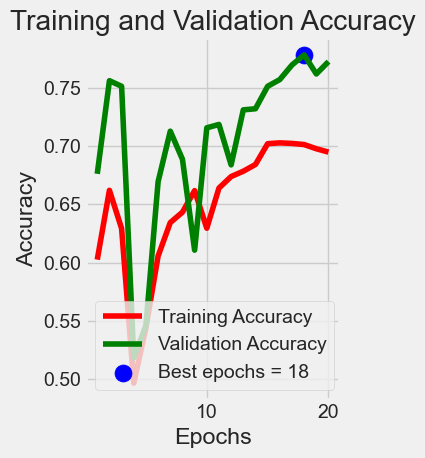

In [50]:
#Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
# Evaluasi model pada data uji
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.7627 - loss: 0.5879
Test Loss: 0.5879303216934204
Test Accuracy: 0.7627118825912476


In [56]:
# Confusion Matrix
y_pred = np.argmax(model.predict(test_gen), axis=-1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step


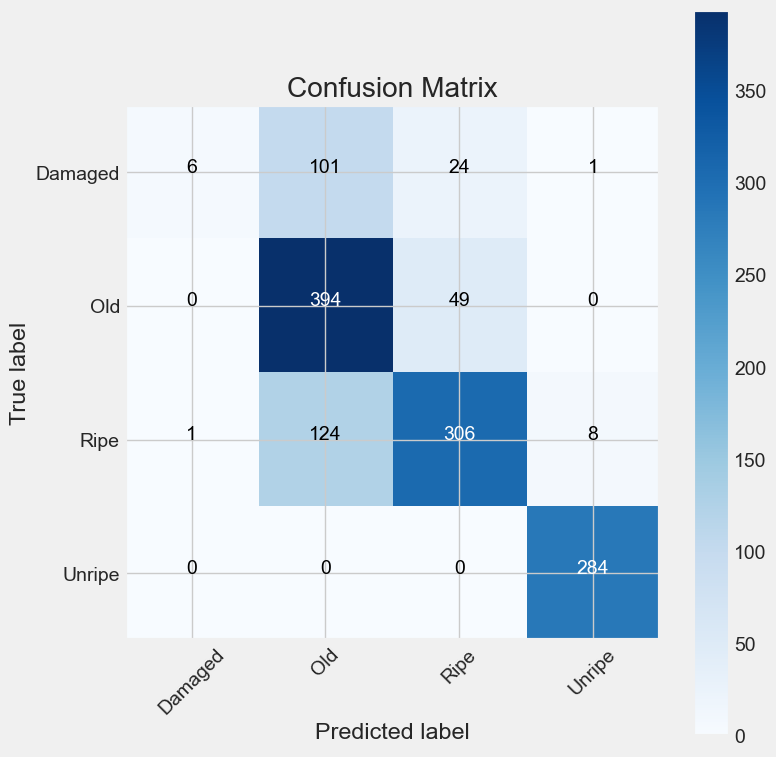

              precision    recall  f1-score   support

     Damaged       0.86      0.05      0.09       132
         Old       0.64      0.89      0.74       443
        Ripe       0.81      0.70      0.75       439
      Unripe       0.97      1.00      0.98       284

    accuracy                           0.76      1298
   macro avg       0.82      0.66      0.64      1298
weighted avg       0.79      0.76      0.73      1298



In [57]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Menambahkan angka di dalam Confusion Matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))

In [58]:
def save_cnn_model_h5(model, filename="cnn_model.h5"):
    model.save(filename)
    print(f"Model berhasil disimpan sebagai: {filename}")


In [59]:
save_cnn_model_h5(model)

Model berhasil disimpan sebagai: cnn_model.h5


In [60]:
from tensorflow.keras.models import load_model

def load_resnet_model(model_path):
    model = load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
    return model


In [ ]:
def save_best_model(model, history, model_name):
    import os

    # keluar dari folder notebook → masuk UAP/model
    save_dir = os.path.join("..", "model")
    os.makedirs(save_dir, exist_ok=True)

    best_val_acc = max(history.history['val_accuracy'])

    path = os.path.join(
        save_dir,
        f"{model_name}_valacc_{best_val_acc:.4f}.h5"
    )

    model.save(path)
    print(f"Best model '{model_name}' disimpan di: {os.path.abspath(path)}")

In [89]:
save_best_model(model, history, "cnn")

Best model 'cnn' disimpan di: c:\Semester 7\ML\UAP\model\cnn_valacc_0.8112.keras
